In [1]:
import os
import pydicom
import numpy as np

def load_dicom_series(folder_path):
    """Load DICOM files from a folder and return a 3D volume (stacked slices)."""
    dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.dicom')]
    dicom_files.sort()  # Sort files by filename to ensure correct order

    # Read DICOM files and extract pixel data into a numpy array
    volume = np.array([pydicom.dcmread(os.path.join(folder_path, f)).pixel_array for f in dicom_files])

    return volume

def load_all_dicom_volumes(segmentation_root):
    """Load all patient DICOM volumes (image and mask) from the segmentation folder."""
    patient_ids = sorted(os.listdir(segmentation_root))  # List of patient folders (e.g., 0001, 0002)

    image_volumes, mask_volumes = [], []

    for pid in patient_ids:
        patient_folder = os.path.join(segmentation_root, pid)
        
        # Check if this is a valid directory (patient folder)
        if not os.path.isdir(patient_folder):
            continue

        # Iterate through the subfolders (folderA, folderB, ...)
        subfolders = sorted(os.listdir(patient_folder))
        
        for subfolder in subfolders:
            subfolder_path = os.path.join(patient_folder, subfolder)
            
            # Check if the subfolder contains 'image' and 'mask' subfolders
            image_path = os.path.join(subfolder_path, 'images')
            mask_path = os.path.join(subfolder_path, 'masks')

            if not os.path.isdir(image_path) or not os.path.isdir(mask_path):
                print(f"Skipping {subfolder} in {pid} due to missing image/mask folder.")
                continue

            # Load the image and mask volumes
            image_volume = load_dicom_series(image_path)
            mask_volume = load_dicom_series(mask_path)

            # Ensure that image and mask volumes have the same shape
            if image_volume.shape != mask_volume.shape:
                print(f"Shape mismatch for {subfolder} in {pid}, skipping...")
                continue

            # Append the loaded volumes
            image_volumes.append(image_volume)
            mask_volumes.append(mask_volume)

    return image_volumes, mask_volumes

# Example usage
segmentation_root = r"C:\Users\abhis\Downloads\liver\Segmentation"  # Path to the segmentation directory
image_volumes, mask_volumes = load_all_dicom_volumes(segmentation_root)

# Check how many volumes were loaded
print(f"Loaded {len(image_volumes)} volumes with images and masks.")

# Check the shape of the first image and mask volume
if len(image_volumes) > 0:
    print(f"First patient image shape: {image_volumes[0].shape}")
    print(f"First patient mask shape: {mask_volumes[0].shape}")

Loaded 310 volumes with images and masks.
First patient image shape: (22, 256, 256)
First patient mask shape: (22, 256, 256)


In [3]:
# Convert 3D volumes into 2D slice pairs (image, mask)
slice_pairs = []

for img_vol, mask_vol in zip(image_volumes, mask_volumes):
    for img_slice, mask_slice in zip(img_vol, mask_vol):
        if np.sum(mask_slice) == 0:
            continue  # skip empty mask slices (optional)
        slice_pairs.append((img_slice, mask_slice))

print(f"Total 2D slice pairs: {len(slice_pairs)}")

Total 2D slice pairs: 12542


In [5]:
import torchvision.transforms as T
from PIL import Image

# Transform: convert to PIL, resize, convert to tensor, normalize
resize_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])  # grayscale normalization
])

In [7]:
from torch.utils.data import Dataset

In [9]:
class LiverSegmentationDataset(Dataset):
    def __init__(self, slice_pairs, image_transform=None, mask_size=(224, 224)):
        self.slice_pairs = slice_pairs
        self.image_transform = image_transform
        self.mask_transform = T.Compose([
            T.ToPILImage(),
            T.Resize(mask_size, interpolation=Image.NEAREST),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.slice_pairs)

    def __getitem__(self, idx):
        image, mask = self.slice_pairs[idx]

        # Ensure image is 3 channels
        image = np.stack([image] * 3, axis=-1).astype(np.uint8)  # (H, W, 3)
        mask = mask.astype(np.uint8)

        if self.image_transform:
            image = self.image_transform(image)
        mask = self.mask_transform(mask)

        return image, mask

In [11]:
from torch.utils.data import DataLoader

dataset = LiverSegmentationDataset(slice_pairs, image_transform=resize_transform)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)


print(f"Total batches: {len(train_loader)}")

Total batches: 1568


In [13]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

C:\Users\abhis\.conda\envs\cirrhosis-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Basic training loop
for epoch in range(10):
    model.train()
    epoch_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = model(imgs)
        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 695.1411
Epoch 2, Loss: 182.1826
Epoch 3, Loss: 146.5633
Epoch 4, Loss: 129.8600
Epoch 5, Loss: 117.1273
Epoch 6, Loss: 108.4564
Epoch 7, Loss: 101.8930
Epoch 8, Loss: 96.9223
Epoch 9, Loss: 93.8568
Epoch 10, Loss: 89.6564


In [17]:
from sklearn.model_selection import train_test_split

# Assuming you already have slice_pairs from loading function
train_slices, val_slices = train_test_split(slice_pairs, test_size=0.2, random_state=42)


In [19]:
# Create datasets
train_dataset = LiverSegmentationDataset(train_slices, image_transform=resize_transform)
val_dataset = LiverSegmentationDataset(val_slices, image_transform=resize_transform)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [25]:
mask = (masks > 0).float()  # convert non-zero values to 1


In [27]:
preds = torch.sigmoid(preds)  # if not auto-applied
preds = (preds > 0.5).float()


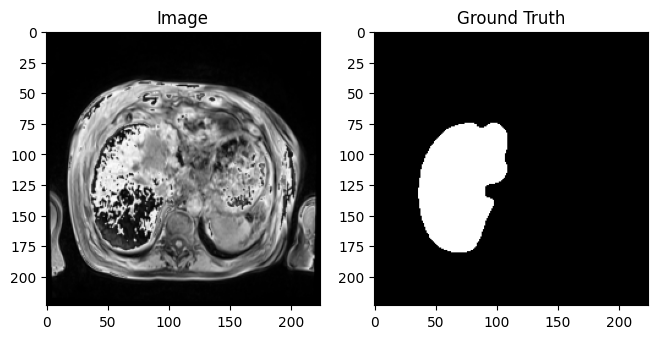

In [39]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        preds = torch.sigmoid(preds)
        preds = (preds > 0.5).float()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(imgs[0][0].cpu(), cmap='gray')
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(masks[0][0].cpu(), cmap='gray')
        plt.show()
        break


In [33]:
def calculate_accuracy(preds, masks):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    correct = (preds == masks).float()
    acc = correct.sum() / correct.numel()
    return acc


In [35]:
model.eval()
total_acc = 0
num_batches = 0

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        
        acc = calculate_accuracy(preds, masks)
        total_acc += acc.item()
        num_batches += 1

print(f"Average Accuracy: {total_acc / num_batches:.4f}")


Average Accuracy: 0.9310


In [121]:
torch.save(model.state_dict(), "efficientnet_liver_segmentation.pth")


In [ ]:
model.load_state_dict(torch.load("efficientnet_liver_segmentation.pth"))
model.eval()
